## LDA (Latent Dirichlet Allocation) Topic modeling

In [ ]:
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
import joblib as jbl
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pyLDAvis
import pandas as pd
from pyLDAvis.lda_model import prepare
from bertopic import BERTopic
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from gensim.models import Word2Vec

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\umap\__init__.py:36: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\pkg_resources\__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


### Loading the dataset, we need clean text

In [2]:
df = jbl.load("preprocessed_df.pkl")
clean_texts = df["clean_text"].values
clean_texts_concatted = [" ".join(sent) for sent in clean_texts]

### Fitting BOW vectorizer on full text

In [3]:
bow = CountVectorizer(lowercase=False, min_df=5, max_df=0.95, ngram_range=(1,1))
X = bow.fit_transform(clean_texts_concatted)
print("Vocabulary:", len(bow.get_feature_names_out()))

Vocabulary: 7061


### LDA

In [4]:
N_TOPICS = 10
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42, max_iter=10, n_jobs=-1)
lda.fit(X)

LatentDirichletAllocation(n_jobs=-1, random_state=42)

### LDA: Top 15 words per topic

In [5]:
# Top 15 words per topic
terms = bow.get_feature_names_out()
topic_terms = []
for k, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-15:][::-1]
    words = [terms[i] for i in top_idx]
    print(f'Topic {k}: ' + ', '.join(words))
    topic_terms.append(words)
lda_topics_df = pd.DataFrame({'topic_id': range(len(lda.components_)), 'top_words': [', '.join(ws) for ws in topic_terms]})
lda_topics_df.head()

Topic 0: water, supply, food, power, also, blanket, well, drinking, system, kit, plant, electricity, hygiene, item, clothing
Topic 1: region, country, year, rain, area, government, crop, drought, season, people, state, last, since, rainfall, province
Topic 2: food, help, need, please, people, water, tent, find, street, house, aid, live, anything, area, lot
Topic 3: said, rain, river, flood, road, heavy, people, official, wind, area, state, north, city, two, day
Topic 4: earthquake, haiti, hurricane, people, sandy, rt, quake, santiago, hit, chile, one, tsunami, island, àö, city
Topic 5: message, note, go, help, find, important, back, person, de, come, see, storm, school, job, never
Topic 6: like, would, know, information, please, good, want, thank, give, need, get, help, earthquake, thanks, call
Topic 7: health, community, child, food, support, project, also, international, emergency, disease, government, assistance, disaster, relief, local
Topic 8: port, au, prince, country, rice, ton,

,topic_id,top_words
0,0,"water, supply, food, power, also, blanket, wel..."
1,1,"region, country, year, rain, area, government,..."
2,2,"food, help, need, please, people, water, tent,..."
3,3,"said, rain, river, flood, road, heavy, people,..."
4,4,"earthquake, haiti, hurricane, people, sandy, r..."


### Visualisation

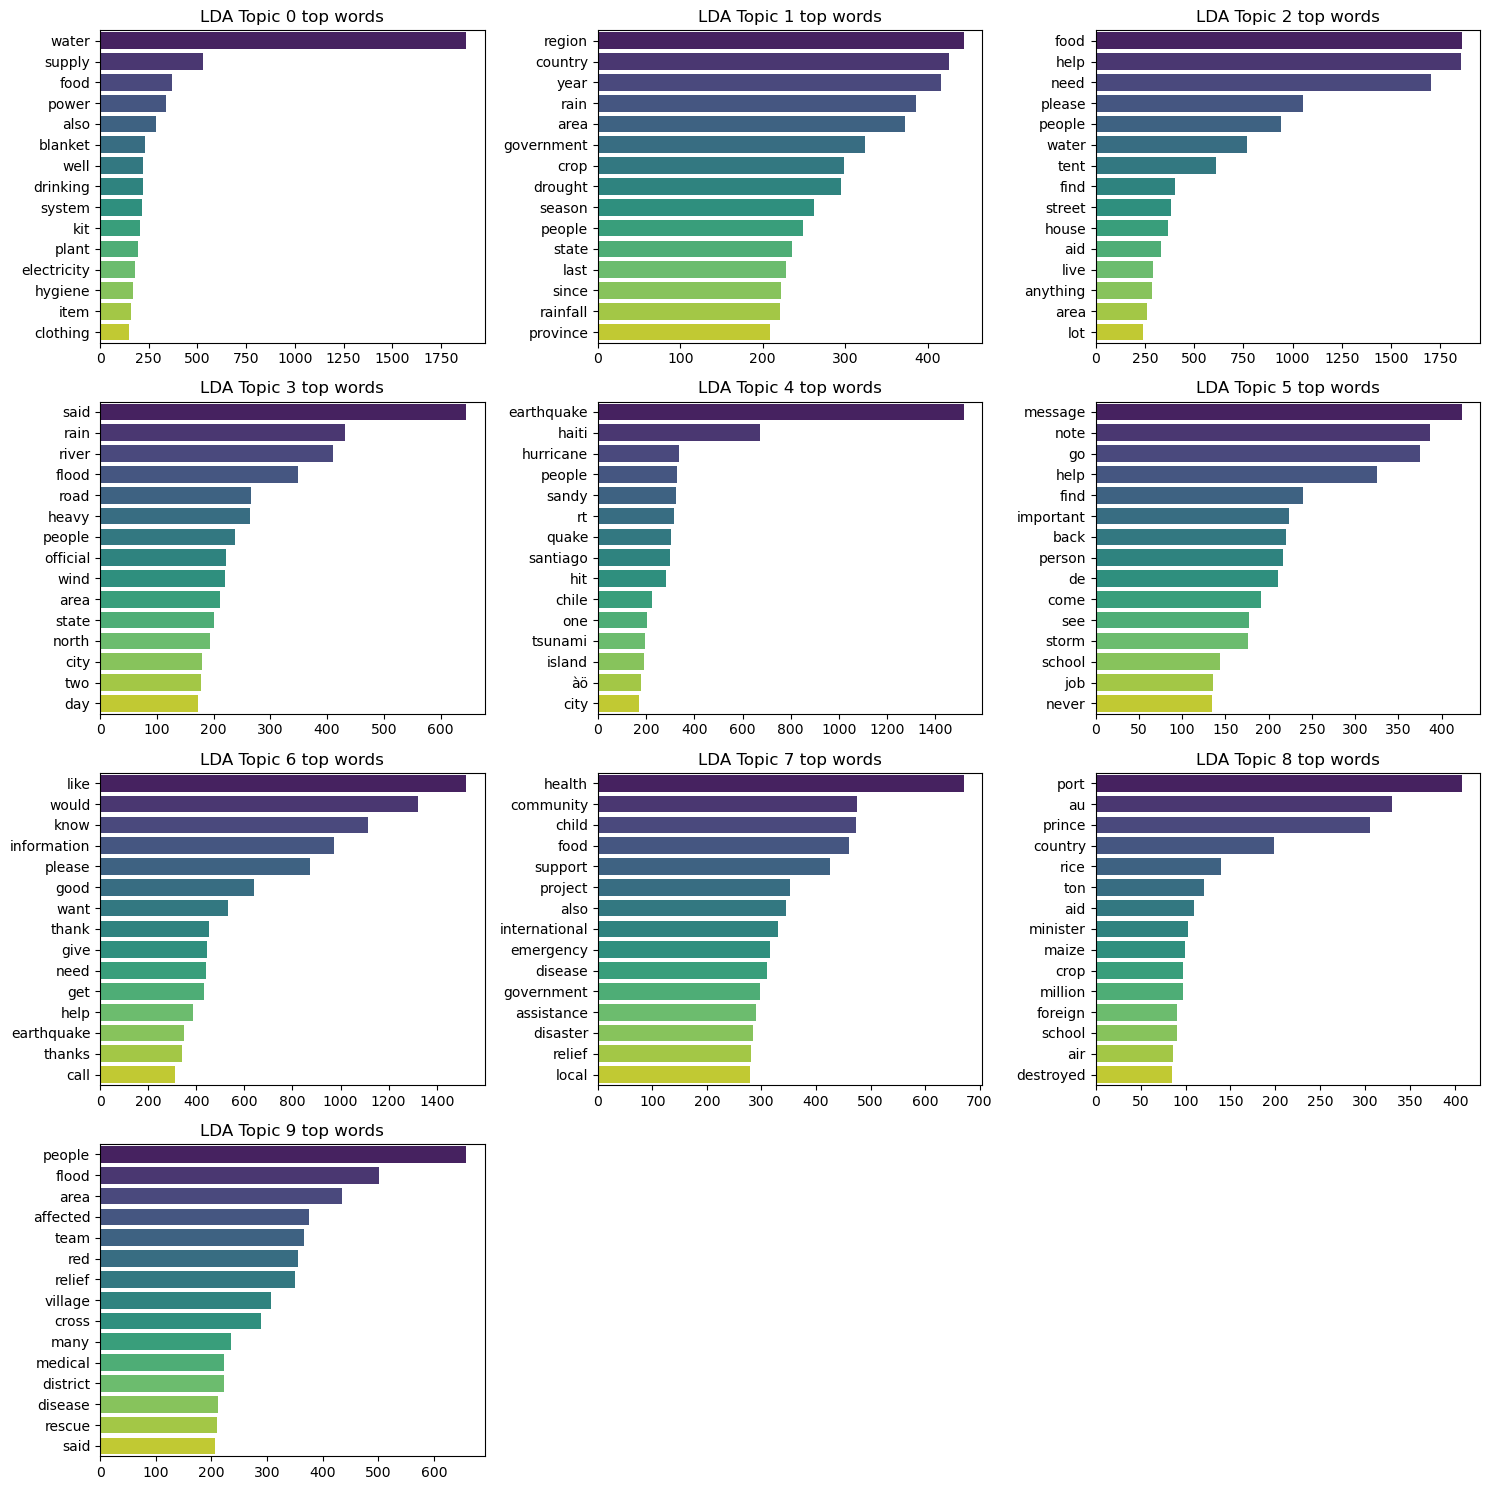

In [6]:
plt.figure(figsize=(15,15))
terms = bow.get_feature_names_out()
for i in range(N_TOPICS):
    plt.subplot(4,3,i+1)
    comp = lda.components_[i]
    top_idx = comp.argsort()[-15:][::-1]
    words = [terms[i] for i in top_idx]
    weights = [comp[i] for i in top_idx]
    sns.barplot(y=words, x=weights, orient="h", palette="viridis")
    plt.title(f'LDA Topic {i} top words')
plt.tight_layout()
plt.show()

### pyLDA interactive visualization

In [7]:
pyLDAvis.enable_notebook()
vis = prepare(lda, X, bow)
display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.106703 -0.169608       1        1  16.210519
1     -0.176177  0.082745       2        1  14.497766
3     -0.155461  0.119907       3        1  11.123722
0     -0.084750 -0.219866       4        1   9.867207
9     -0.123377 -0.005530       5        1   9.815499
6      0.290370  0.054769       6        1   9.577881
2      0.244300 -0.128221       7        1   9.165760
4     -0.030522  0.234556       8        1   8.213269
5      0.256824  0.059148       9        1   5.766387
8     -0.114504 -0.027898      10        1   5.761989, topic_info=            Term         Freq        Total Category  logprob  loglift
6870       water  2986.000000  2986.000000  Default  30.0000  30.0000
2911        help  2535.000000  2535.000000  Default  29.0000  29.0000
2468        food  2800.000000  2800.000000  Default  28.0000  28.0000
1943  earthquake  1805.000000  1805.000000  Default  27.0000  27.0000
4184        need  2378.000000  2378.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2711  government    74.138838  1036.000950  Topic10  -5.5247   0.2167
2993       house    71.868451   906.386771  Topic10  -5.5558   0.3193
5464        said    73.571874  1342.193669  Topic10  -5.5324  -0.0499
7015        year    69.457121   940.336679  Topic10  -5.5899   0.2484
2301      family    68.660404   833.574056  Topic10  -5.6015   0.3573

[760 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
63        1  0.073680  across
63        2  0.291370  across
63        3  0.375097  across
63        5  0.073680  across
63        7  0.053585  across
...     ...       ...     ...
7015      8  0.103155    year
7015      9  0.094647    year
7015     10  0.073378    year
7059      8  0.993231      àö
7060      8  0.971904      àû

[1958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 4, 1, 10, 7, 3, 5, 6, 9])

### Brief interpretation

**Topic 0 – Basic Needs:**
Water, food, power, hygiene, clothing: Essential supplies and infrastructure recovery.

**Topic 1 – Drought & Agriculture:**
Rain, crop, drought, rainfall, province: Regional drought and agricultural impacts.

**Topic 2 – Requests for Help:**
Help, need, water, tent, aid: Personal pleas for aid and local needs.

**Topic 3 – Flooding:**
Rain, river, flood, road, wind: Floods and weather-related damage.

**Topic 4 – Major Disasters:**
Earthquake, haiti, hurricane, sandy, tsunami: Earthquake and hurricane events

**Topic 5 – Communication:**
Message, find, see, job, school: General communication and coordination.

**Topic 6 – Gratitude & Requests:**
Like, thank, want, help, call: Social interaction, thanks, and information seeking.

**Topic 7 – Health & Aid:**
Health, community, project, disease, relief: Public health and humanitarian support.

**Topic 8 – Haiti Reconstruction:**
Port, au, prince, rice, aid, school: Haiti-specific recovery and aid logistics.

**Topic 9 – Flood Response:**
People, flood, red, cross, rescue, medical: Relief teams and rescue operations.

**Overall:**
The topics are coherent and cover key disaster themes — needs, response, communication, and recovery across floods, droughts, and earthquakes, aligns well with marked category labels


## BERTopic: topics, top words, and visualization

### Word2Vec Embeddings (TF-IDF weighted)

Was working badbly so it was decided to use built in more context aware embedding model in BERTopic

In [8]:
EMBED_DIM = 50
model = Word2Vec(clean_texts, window=5, vector_size=EMBED_DIM, epochs=10, sg=1, min_count=5)
# TF-IDF 
vectorizer = TfidfVectorizer(lowercase=False, min_df=5, max_df=0.95, ngram_range=(1,1))
X_tfidf = vectorizer.fit_transform(clean_texts_concatted)
vocab = vectorizer.get_feature_names_out()

# embedding matrix for vocabulary
dim = int(model.vector_size)
V = np.zeros((len(vocab), dim), dtype=np.float32)
in_vocab = 0
w2v_vocab = set(model.wv.key_to_index.keys())
for i, term in enumerate(vocab):
    if term in w2v_vocab:
        V[i] = model.wv[term]
        in_vocab += 1

# TF-IDF weighted average to get doc embeddings
doc_embeddings = X_tfidf.dot(V)
norm = np.linalg.norm(doc_embeddings, axis = 1, keepdims=True)
doc_embeddings = np.divide(doc_embeddings, norm, where= norm != 0)
doc_embeddings[np.argwhere(norm == 0)] = 0
print(f"Built doc_embeddings: shape={doc_embeddings.shape}, vocab={len(vocab)}, covered={in_vocab}")

Built doc_embeddings: shape=(26216, 50), vocab=7061, covered=7061


### BERTopic fit

Dimensionality reduction can be handled using PCA instead of UMAP, cluctering can be then done using Kmeans instead of HDBSCAN

In [9]:
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.cluster import KMeans
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.001, metric='euclidean') #10
#hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=2, cluster_selection_method='eom') #50

topic_model = BERTopic(verbose=True, nr_topics=10, top_n_words=15, umap_model=umap_model, hdbscan_model=KMeans(n_clusters=10))
topics, probs = topic_model.fit_transform(clean_texts_concatted)#, embeddings=doc_embeddings)
topic_info = topic_model.get_topic_info()
display(topic_info)

2025-11-02 16:16:08,402 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 820/820 [00:12<00:00, 67.64it/s]
2025-11-02 16:16:23,195 - BERTopic - Embedding - Completed ✓
2025-11-02 16:16:23,196 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-02 16:17:00,654 - BERTopic - Dimensionality - Completed ✓
2025-11-02 16:17:00,656 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-02 16:17:01,116 - BERTopic - Cluster - Completed ✓
2025-11-02 16:17:01,117 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-02 16:17:01,648 - BERTopic - Representation - Completed ✓
2025-11-02 16:17:01,649 - BERTopic - Topic reduction - Reducing number of topics
2025-11-02 16:17:01,650 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(10).
2025-11-02 16:17:01,651 - BERTopic - Representation - Fine-tuning topics using representation mode

,Topic,Count,Name,Representation,Representative_Docs
0,0,1007,0_sandy_hurricane_storm_power,"[sandy, hurricane, storm, power, amp, nyc, day...","[hurricane, four hurricane sandy go hurricane ..."
1,1,3839,1_message_like_please_information,"[message, like, please, information, know, wou...","[like information please, see message would li..."
2,2,3167,2_water_health_disease_food,"[water, health, disease, food, child, medical,...",[ministry public health also ordered provincia...
3,3,1297,3_haiti_earthquake_haitian_rt,"[haiti, earthquake, haitian, rt, passport, lik...","[information earthquake haiti, information hai..."
4,4,2445,4_help_house_please_port,"[help, house, please, port, need, people, au, ...",[flooded port au prince live gonaives need hel...
5,5,2870,5_government_international_country_group,"[government, international, country, group, sa...",[fact sheet summarizes effort october provide ...
6,6,1481,6_earthquake_quake_tsunami_information,"[earthquake, quake, tsunami, information, peop...","[information earthquake, information earthquak..."
7,7,614,7_santiago_chile_concepcion_aftershock,"[santiago, chile, concepcion, aftershock, rt, ...","[continued aftershock santiago, waiting earthq..."
8,8,3217,8_food_need_tent_water,"[food, need, tent, water, help, please, people...","[help need food water, please please help need..."
9,9,6279,9_flood_rain_area_water,"[flood, rain, area, water, people, said, crop,...",[day slept dreamt cold breeze blowing landslid...


### Interactive BERTopic visualization

In [10]:
# Plotly
fig = topic_model.visualize_topics(use_ctfidf=True)
fig.show()

### Bar chart 

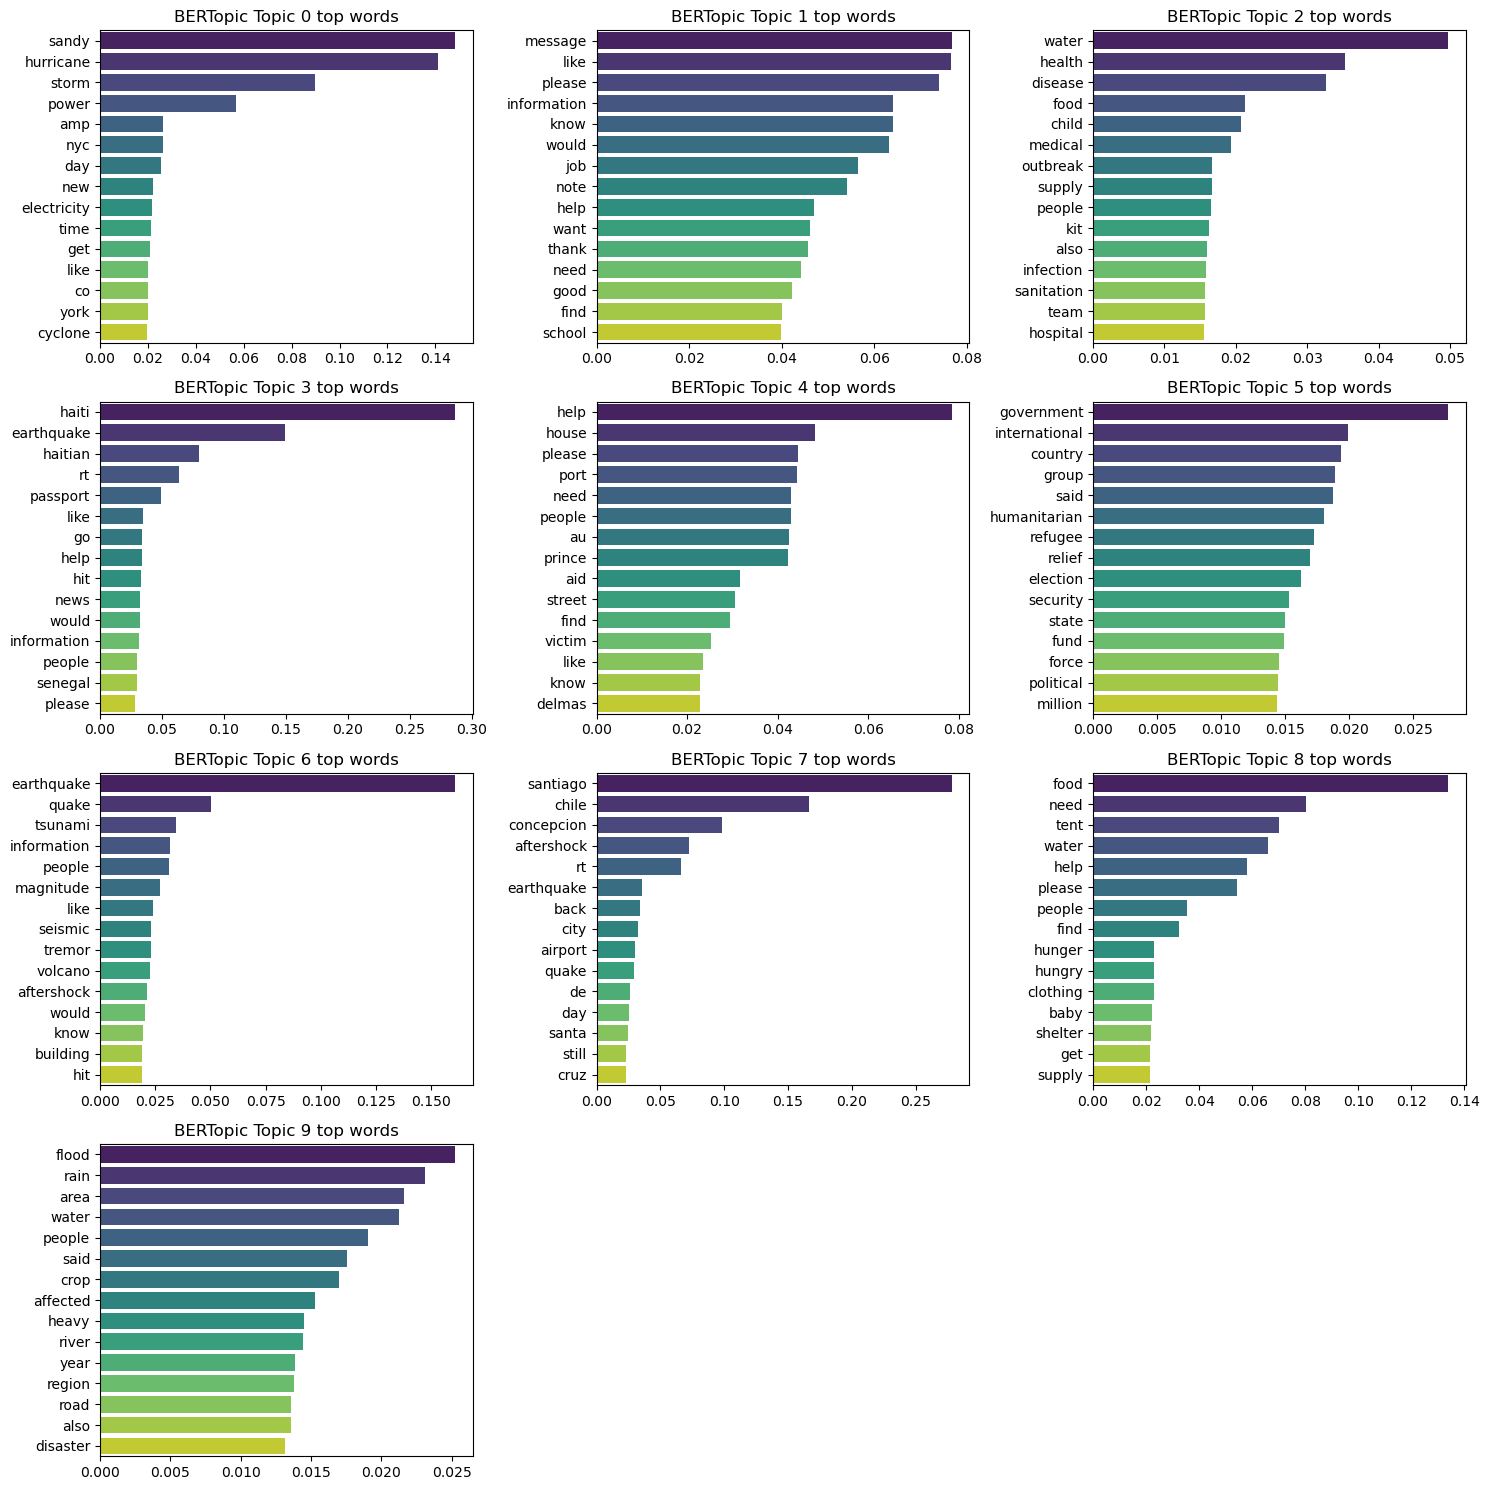

In [11]:

plt.figure(figsize=(15,15))
i = 0
for tid in topic_model.get_topics().keys():
    plt.subplot(4,3,i+1)
    i+=1
    terms = topic_model.get_topic(tid)
    words = [w for w,_ in terms]
    weights = [wgt for _,wgt in terms]
    sns.barplot(y=words, x=weights, orient="h", palette="viridis")
    plt.title(f'BERTopic Topic {tid} top words')
plt.tight_layout()
plt.show()

## Brief summary


**Topic 0 – Hurricane Sandy:**
sandy, hurricane, storm, power, nyc: Posts about Hurricane Sandy and related storm impacts.

**Topic 1 – Communication & Information Requests:**
message, like, please, information, know: General messaging, info-seeking, and personal updates.

**Topic 2 – Water & Health Issues:**
water, health, disease, food, child, medical: Public-health concerns and basic-needs discussion.

**Topic 3 – Haiti Earthquake (General):**
haiti, earthquake, haitian, rt, passport: News and reactions around the Haiti earthquake.

**Topic 4 – Requests for Help (Port-au-Prince):**
help, house, port, need, au: Direct pleas for assistance and local damage reports.

**Topic 5 – Government & International Response:**
government, international, country, group, support: Official or NGO relief coordination.

**Topic 6 – Earthquake & Tsunami Information:**
earthquake, quake, tsunami, information, people: Event information and public alerts.

**Topic 7 – Chile Earthquake Aftershocks:**
santiago, chile, concepcion, aftershock: Reports from Chile following the earthquake.

**Topic 8 – Basic Aid Needs:**
food, need, tent, water, help: Requests for basic humanitarian supplies.

**Topic 9 – Floods & Rainfall Damage:**
flood, rain, area, water, crop: Flooding, rain impact, and agricultural losses.

**Overall summary:**
BERTopic cleanly separates specific disaster events (Hurricane Sandy, Haiti, Chile, floods) from response themes* (health, aid requests, government coordination). Topics are coherent and event-focused, with clear clusters for both **crisis types** and **relief activities**.
